In [354]:
#author = 0712238@NCTU, Maxwill Lin, YT Lin
#last update = 2019.11.07
#usage = HW1 of Deep Learning 2019 fall @ NCTU 
#regression part 
#preprocess with normaliztion and one-hot vectorization
#NN architectur = NN([17, 10, 5, 1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')
#train and test with split data set
#learning curve + train/test RMS
#save files
#2019.11.06-07 some bug fixed, improvement on weight init, experiments

In [355]:
import numpy as np
import math
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle

In [356]:
import numpy as np

class NN(object):
    def __init__(self, layers = [10 , 20, 1], activations=['sigmoid', 'relu'], usage = 'regression'):
        #my model is very sensitive to initial value sometimes
        #maybe the gradient descent method is too naive
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.weights = []
        self.biases = []
        self.usage = usage
        for i in range(len(layers)-1):
            if self.activations[i] in ['relu', 'selu', 'elu']:
                self.weights.append(np.random.randn(layers[i+1], layers[i])*np.sqrt(2./layers[i])) #heuristic
                self.biases.append(np.random.randn(layers[i+1], 1)*0.1) #can be 0
            else:
                self.weights.append(np.random.randn(layers[i+1], layers[i])*np.sqrt(1./layers[i])) #heuristic
                self.biases.append(np.random.randn(layers[i+1], 1)*0.1) #can be 0


    def feedforward(self, x): #x = dim*num
        ai = np.copy(x)
        z_s = []
        a_s = [ai]
        for i in range(len(self.weights)):
            z_s.append(self.weights[i].dot(ai) + self.biases[i])
            ai = self.AF(self.activations[i])(z_s[-1])
            a_s.append(ai)
        return z_s, a_s

    def backpropagation(self,y, z_s, a_s): #y = 1*num
        dw = []  # dJ/dW
        db = []  # dJ/dB
        deltas = [None] * len(self.weights)  # delta = dJ/dZ, error for each layer

        #delta out
        delta_out = self.dJ(self.usage)(a_s[-1], y)
        #last layer delta
        deltas[-1] = delta_out*(self.dAF(self.activations[-1]))(z_s[-1])
        #backpro
        for i in reversed(range(len(deltas)-1)):
            deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.dAF(self.activations[i])(z_s[i]))
        batch_size = y.shape[1]
        db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
        dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]

        #eps = 0.001
        #for i in range(len(dw)):
        #    assert(np.linalg.norm(dw[i]) > eps)
        return dw, db

    def train(self, x, y, batch_size=10, epochs=100, lr = 0.1): #x = num*dim #y = num*dim
        #record cost by epchos
        learning_curve = []

        #mini batch
        #assert(x.shape[0] >= batch_size*epochs)
        indices = np.arange(x.shape[0])#debug if 0
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for e in range(epochs):
            i=0
            #print("len y  ", len(y))
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                x_batch = x_batch.T
                y_batch = y_batch.T
                #print(x_batch.shape)
                #print(y_batch.shape)
                i += batch_size
                z_s, a_s = self.feedforward(x_batch)
                dw, db = self.backpropagation(y_batch, z_s, a_s)
                #eps = 0.001
                #for i in range(len(dw)):
                #    if(np.linalg.norm(dw[i]) < eps):
                #        print("0 gradient @ epcho ", e*10)
                self.weights = [wi+lr*dwi for wi,dwi in  zip(self.weights, dw)]
                self.biases = [bi+lr*dbi for bi,dbi in  zip(self.biases, db)]
                loss = self.J(self.usage)(a_s[-1],y_batch)
            #if(e%(epochs/10)== 0):
            learning_curve.append(loss) #to expand
            #print("loss = {}".format(np.linalg.norm(a_s[-1]-y_batch))) #to expand
        return learning_curve


    def calc_error(self, test_X, test_y): #num*dim
        _, a_s = self.feedforward(test_X.T)
        return  self.J(self.usage)(a_s[-1], test_y.T)

    def prediction(self, X): #num*dim
        _, a_s = self.feedforward(X.T)
        return a_s[-1]

    def calc_accuracy(self, test_X, test_y): #num*dim
        _, a_s = self.feedforward(test_X.T)
        n = a_s[-1].shape[1]
        total = 0.
        correct = 0.
        for i in range(n):
            total += 1
            if (a_s[-1][0][i] >= 0.5) == bool(test_y[i]):
                correct += 1
        return  correct/total

    @staticmethod
    def AF(name):
        if(name == 'sigmoid'):
            def sig(x):
                x = np.clip(x , -10., 10.)
                return np.exp(x)/(1+np.exp(x))
            return sig
        elif(name == 'linear'):
            return lambda x : x
        elif(name == 'relu'):
            def relu(x):
                return np.where(x<0,0,x)
            return relu
        elif(name == 'selu'):
            def selu(x,lamb=1.0507009873554804934193349852946, alpha=1.6732632423543772848170429916717):
                x = np.clip(x , -100., 100.)
                return lamb*np.where(x<0,alpha*(np.exp(x) - 1),x)
            return selu
        else:
            print('unknown activation function => linear')
            return lambda x: x

    @staticmethod
    def dAF(name):
        if(name == 'sigmoid'):
            def dsig(x):
                x = np.clip(x , -10., 10.)
                sigx = np.exp(x)/(1+np.exp(x))
                return sigx*(1-sigx)
            return dsig
        elif(name == 'linear'):
            return lambda x: 1
        elif(name == 'relu'):
            def drelu(x):
                return np.where(x<0,0,1)
            return drelu
        elif(name == 'selu'):
            def dselu(x,lamb=1.0507009873554804934193349852946, alpha=1.6732632423543772848170429916717):
                x = np.clip(x , -100., 100.)
                return lamb*np.where(x<0,alpha*np.exp(x),1)
            return dselu
        else:
            print('unknown activation function => linear derivative')
            return lambda x: 1

    @staticmethod
    def dJ(name):
        if(name == 'regression'):
            return lambda x, y: y-x
        if(name == 'classification'):
            def dCE(yhat, y):
                epsilon=1e-12
                yhat = np.clip(yhat, epsilon, 1. - epsilon)
                return np.divide(y, yhat) - np.divide(1 - y, 1 - yhat)
            return dCE
        else:
            print('unknown usage => regression')
            return lambda x, y: y-x

    @staticmethod
    def J(name):
        if(name == 'regression'):
            return lambda x, y: np.linalg.norm(y-x)/np.sqrt(max(y.shape[0], y.shape[1])) #RMS
        if(name == 'classification'):
            def cross_entropy(yhat, y):
                epsilon=1e-12
                yhat = np.clip(yhat, epsilon, 1. - epsilon)
                n = yhat.shape[1]
                ce = -np.sum(y*np.log(yhat))/n
                return ce
            return cross_entropy
        else:
            print('unknown usage => regression')
            return lambda x, y: np.linalg.norm(y-x)/np.sqrt(max(y.shape[0], y.shape[1])) #RMS


In [357]:
#preprocessing
df = pd.read_csv("EnergyEfficiency_data.csv")

In [358]:
def get_onehot(df, name):
    A = df[name].values
    n = A.shape[0]
    onehot_A = np.zeros((n,max(A)-min(A)+1))
    onehot_A[np.arange(n), A-min(A)] = 1
    return onehot_A

def normalize(X):
    s = [ np.mean(dim) for dim in X.T]
    X = np.asarray([np.divide(x, s) for x in X])
    return X

O = get_onehot(df, "Orientation")
G = get_onehot(df, "Glazing Area Distribution")
y = df["Heating Load"].values.reshape((-1,1))
y.shape
Other = df.drop(['Orientation', 'Glazing Area Distribution', "Heating Load"], axis=1).values

X = np.c_[normalize(Other), O, G]
assert(X.shape[1] == O.shape[1]+G.shape[1]+Other.shape[1])

def partition(X, y, ratio=0.75):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    p = int(n*ratio)
    train_X = X[:p]
    test_X = X[p:]
    train_y = y[:p]
    test_y = y[p:]
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = partition(X, y, ratio=0.75)

In [359]:
[1., 2., 3., 4., 5.]
avg_lc = [[1.]*3]*3
avg_lc = [[y/2 for y in x] for x in avg_lc]   
[1., 2., 3., 4., 5.]+[2., 3., 4., 5., 6.]

[1.0, 2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [360]:
#exp on lr
exp_times = 10
epochs = 70

lrs = [0.01, 0.05, 0.08, 0.1, 0.15, 0.5]
n = len(lrs)
avg_lc = [[0.]*epochs]*n
avg_train_RMS = [0.]*n
avg_test_RMS = [0.]*n


for T in range(exp_times):
    print("exp #", T, end=' ')
    train_X, train_y, test_X, test_y = partition(X, y, ratio=0.75)
    for i in range(n):
        #test lr with model [in , 10, 5, 1], sig, sig, linear
        #lr = 0.5 => too large, 0.1 => ok, 0.01 =>  smooth and as good as 0.1
        nn = NN([train_X.shape[1], 10, 5,  1],activations=['sigmoid', 'sigmoid', 'linear'], usage = 'regression')
        learning_curve = nn.train(train_X, train_y, epochs=epochs, batch_size=10, lr = lrs[i])
        train_RMS = nn.calc_error(train_X, train_y)
        test_RMS = nn.calc_error(test_X, test_y)
        
        avg_lc[i] = [avg_lc[i][k] + learning_curve[k] for k in range(len(avg_lc[i]))]
        avg_train_RMS[i] += train_RMS
        avg_test_RMS[i] += test_RMS


exp # 0 exp # 1 exp # 2 exp # 3 exp # 4 exp # 5 exp # 6 exp # 7 exp # 8 exp # 9 

lr = 0.01, train_RMS =  1.6272838169649901 
 test_RMS =  1.746094956658628
lr = 0.05, train_RMS =  1.362127482586276 
 test_RMS =  1.5505894928969388
lr = 0.08, train_RMS =  1.3660866060390215 
 test_RMS =  1.6068230627166975
lr = 0.1, train_RMS =  1.3654542636169285 
 test_RMS =  1.616066645966939
lr = 0.15, train_RMS =  4.082243367158145 
 test_RMS =  4.193966068207461
lr = 0.5, train_RMS =  10.811314791662266 
 test_RMS =  10.730692461714677


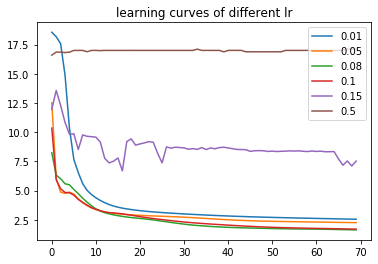

In [361]:
avg_lc = [[y/n for y in x] for x in avg_lc]      
avg_train_RMS = [i/exp_times for i in avg_train_RMS]
avg_test_RMS = [x/exp_times for x in avg_test_RMS]

plt.title("learning curves of different lr")

for i in range(n):        
    plt.plot(np.arange(len(avg_lc[i])), avg_lc[i], label='{}'.format(lrs[i]))
    print('lr = '+ str(lrs[i]) +', train_RMS = ', avg_train_RMS[i], '\n', 'test_RMS = ', avg_test_RMS[i])

plt.legend() 


In [ ]:
for i in range(n):        
    plt.title("learning cure with lr={}".format(lrs[i]))
    plt.plot(np.arange(len(learning_curve)), learning_curve, label='lr={}'.format(lrs[i]))
    print('train_RMS = ', train_RMS, '\n', 'test_RMS = ', test_RMS)

plt.legend()

In [75]:
def save_res(name):
    pathcsv = "./predictions/"
    reg_train_csv = pathcsv + "reg_train_pred_"+name+".csv" 
    reg_test_csv = pathcsv + "reg_test_pred_"+name+".csv" 
    with open(reg_train_csv, 'w', newline='') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(['prediction', 'label'])
        for i in range(train_X.shape[0]):
            writer.writerow([nn.prediction(np.asarray([train_X[i]]))[0][0], train_y[i][0]])
    with open(reg_test_csv, 'w', newline='') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(['prediction', 'label'])
        for i in range(test_X.shape[0]):
            writer.writerow([nn.prediction(np.asarray([test_X[i]]))[0][0], test_y[i][0]])
            
    pathnn = "./savedmodels/"
    savefilename = pathnn +"reg_nn_"+name
    with open(savefilename, 'wb') as fo:
        pickle.dump(nn, fo)

save_res("1107-1")

FileNotFoundError: [Errno 2] No such file or directory: './predictions/reg_train_pred_1107-1.csv'

In [223]:
#nn = NN([train_X.shape[1], 10, 5,  1],activations=['sigmoid', 'sigmoid', 'relu'], usage = 'regression')
nn = NN([train_X.shape[1], 10, 5,  1],activations=['selu', 'selu', 'linear'], usage = 'regression')
z_s, a_s = nn.feedforward(X.T)
#dw, db = nn.backpropagation(y.T, z_s, a_s)
#print(dw)

In [131]:
print(nn.weights)

[array([[-0.08782223,  0.17636422,  0.51567874, -0.06583622,  0.37120905,
         0.51373374,  0.23176842, -0.08893359,  0.15595829,  0.18662449,
         0.51095573, -0.3921438 , -0.08301767,  0.15347536, -0.55125672,
         0.13919219, -0.24498976],
       [ 0.13064503, -0.21079076,  0.27790895, -0.20396424,  0.33110603,
         0.16900299,  0.48094283, -0.04551837, -0.15986166,  0.07217667,
         0.20198217, -0.07453665,  0.12330061, -0.88268454,  0.09646616,
         0.86280573,  0.01680349],
       [ 0.03555072, -0.05100541,  0.13535274,  0.63930314,  0.13191886,
         0.32245713,  0.26234304,  0.29480255,  0.08604815, -0.22375003,
         0.19297176, -0.51485125, -0.16752672, -0.28392996, -0.04181313,
        -0.11872433, -0.16974331],
       [ 0.11979631, -0.11396559, -0.46795064, -0.4013274 , -0.45104869,
        -0.76570025, -0.13510735, -0.30059603,  0.22080355,  0.31868432,
         0.06022368,  0.58366743,  0.25932753,  0.15672163,  0.2197435 ,
        -0.8327302

In [132]:
print(nn.calc_error(X, y))
dw = []  # dJ/dW
db = []  # dJ/dB
deltas = [None] * len(nn.weights)  # delta = dJ/dZ, error for each layer


24.665771889569072


In [364]:
print((y.T-a_s[-1]).shape)
delta_out = nn.dJ(nn.usage)(a_s[-1], y.T)
delta_out.shape



(1, 768)


array([5, 6])

In [138]:
deltas[-1] = delta_out*((nn.dAF(nn.activations[-1]))(z_s[-1]))
deltas[-1].shape

(1, 768)

In [178]:
x = np.asarray([[1, 2, 3, -1, -1]])
y = np.asarray([[1, 2, 3, -1, -1], [1, -1, -1, 2, 3]])
np.where(y>0, y, 0)

array([[1, 2, 3, 0, 0],
       [1, 0, 0, 2, 3]])

In [142]:
print(nn.dAF(nn.activations[-2])(z_s[-2]).shape)
#nn.weights[-1].T.dot(deltas[-1])
deltas[-2] = nn.weights[-1].T.dot(deltas[-1])*(nn.dAF(nn.activations[-2])(z_s[-2]))
print(deltas[-2].shape)

for i in reversed(range(len(deltas)-1)):
    deltas[i] = nn.weights[i+1].T.dot(deltas[i+1])*(nn.dAF(nn.activations[i])(z_s[i]))
    #print(deltas[i][-1])

(5, 768)
(5, 768)


In [147]:
batch_size = 768
db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
print([x.shape for x in dw])
print(dw)

[(10, 17), (5, 10), (1, 5)]
[array([[-6.20462410e+00, -5.73517571e+00, -6.17764704e+00,
        -5.33618422e+00, -6.82820491e+00, -7.15764520e+00,
        -7.24948268e+00, -1.49837976e+00, -1.26613962e+00,
        -1.54827185e+00, -1.65827541e+00,  5.81773732e-02,
        -1.40894961e+00, -7.81809734e-01, -1.31361667e+00,
        -1.36787567e+00, -1.15699232e+00],
       [-2.85576398e+01, -2.65016941e+01, -2.83656445e+01,
        -2.48209064e+01, -3.11772470e+01, -3.07075954e+01,
        -3.24819096e+01, -7.08800160e+00, -6.40103540e+00,
        -6.97242233e+00, -7.07115473e+00, -6.57157841e-01,
        -5.58470414e+00, -4.79357159e+00, -5.51495394e+00,
        -5.68082935e+00, -5.30139720e+00],
       [-2.19250660e+01, -2.02503640e+01, -2.17104449e+01,
        -1.89337593e+01, -2.39862765e+01, -2.36388434e+01,
        -2.49847597e+01, -5.51827940e+00, -4.90505645e+00,
        -5.18351967e+00, -5.48216478e+00, -4.46110332e-01,
        -4.34889077e+00, -3.52726222e+00, -4.23634920e+00,


In [ ]:
def backpropagation(self,y, z_s, a_s): #y = 1*num
    dw = []  # dJ/dW
    db = []  # dJ/dB
    deltas = [None] * len(self.weights)  # delta = dJ/dZ, error for each layer

    #delta out
    delta_out = self.dJ(self.usage)(a_s[-1], y)
    #last layer delta
    deltas[-1] = delta_out*(self.dAF(self.activations[-1]))(z_s[-1])
    #backpro
    for i in reversed(range(len(deltas)-1)):
        deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.dAF(self.activations[i])(z_s[i]))
    batch_size = y.shape[1]
    db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
    dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]

    #eps = 0.001
    #for i in range(len(dw)):
    #    assert(np.linalg.norm(dw[i]) > eps)
    return dw, db